# Web scraping to find best deals at the best time
- Uses Selenium to scrape popular deals website

To do:
- Fix time column

In [21]:
from selenium import webdriver  
from selenium.webdriver.chrome.options import Options  
from selenium.webdriver.common.keys import Keys
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from dateutil.parser import parse
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
import re
import time
import sys

In [11]:
def clean_date(date_entry):
    temp = date_entry.split()
    if temp[-1] == "ago":
        # return dt.datetime.today().strftime("%d/%m/%Y")
        return pd.to_datetime("today")
    elif temp[0] == "Made":
        return parse(" ".join(temp[-2:]))
    else:
        return np.nan


def clean_company(company_entry):
    # reverse split to split by last space symbol
    try:
        return company_entry.rsplit(" ", 1)[0]
    except:
        return np.nan


def clean_price(price_entry):
    try:
        temp = price_entry[1:]
        temp = temp.replace(",", "")
        return round(float(temp))
    except:
        return np.nan


def clean_heat(heat_entry):
    temp = heat_entry[:-1]
    try:
        return int(temp)
    except:
        return np.nan


def clean_item(item_entry):
    # take out price from title
    # filter returns element for which condition is true
    lst = ["prime", "black", "delivered", "code"]
    res = " ".join(filter(lambda x: x[0] != "£", item_entry.split()))
    res = " ".join(filter(lambda x: x not in lst, res.split()))
    return res


def get_top_twenty_words(df, n_comp):
    """
    Takes dataframe of text (title, description, key ingredient) and uses truncated SVD to reduce down to n components
    """
    vectorizer = TfidfVectorizer(stop_words="english", strip_accents="unicode")
    vec = vectorizer.fit_transform(df)
    tfidf = pd.DataFrame(vec.todense(), columns=vectorizer.get_feature_names())
    svd = TruncatedSVD(n_components=n_comp, n_iter=7, random_state=42)
    svd_ft = svd.fit_transform(tfidf)
    df_comp = pd.DataFrame(svd.components_, columns=tfidf.columns)
    df_comp = df_comp.T
    return np.mean(df_comp.abs(), axis=1).sort_values(ascending=False).head(30)

## Data collection

In [32]:
# Set headless browser
options = Options()
options.headless = True
chromeOptions = webdriver.ChromeOptions() 
chromeOptions.add_argument("--remote-debugging-port=9222")

In [33]:
df = pd.DataFrame(columns=['Item', 'Price', 'Company', 'Heat', 'Date'])

for page_no in range(1,5001):
    print(page_no)
    driver = webdriver.Chrome('chromedriver.exe', chrome_options=options)
    driver.get('https://www.hotukdeals.com/tag/electronics?page='+str(page_no))
    item_data = driver.find_elements_by_class_name('threadGrid-title')  # get title, price, company
    forum_data = results = driver.find_elements_by_class_name('threadGrid-headerMeta')  # get heat, date

    df_item = pd.DataFrame(columns=['Item', 'Price', 'Company'])
    for i in range(len(item_data)):
        temp = item_data[i].text.split('\n')
        try:
            df_item.loc[i] = [temp[0], temp[1], temp[-1]]
        except:
            df_item.loc[i] = np.nan

    df_forum = pd.DataFrame(columns=['Heat', 'Date'])
    for i in range(len(forum_data)):
        temp = forum_data[i].text.split('\n')
        try:
            df_forum.loc[i] = [temp[0], temp[-1]]
        except:
            df_forum.loc[i] = np.nan

    df_temp = pd.concat([df_item, df_forum], axis=1)
    df = pd.concat([df, df_temp], axis=0)

# Clean item
df['Item'] = df['Item'].map(lambda x: clean_item(x))
# Clean price
df['Price'] = df['Price'].map(lambda x: clean_price(x))
# Clean company
df['Company'] = df['Company'].map(lambda x: clean_company(x))
# Clean date
df['Date'] = df['Date'].map(lambda x: clean_date(x))
# Clean heat
df['Heat'] = df['Heat'].map(lambda x: clean_heat(x))
# Drop NAN
# df = df.dropna()
# df = df.reset_index(drop=True)

df.to_csv('data/hukd_5000_pages.csv', index=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


IndexError: list index out of range

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2001 entries, 0 to 19
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Item     2001 non-null   object        
 1   Price    1940 non-null   float64       
 2   Company  2001 non-null   object        
 3   Heat     2000 non-null   float64       
 4   Date     1853 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 93.8+ KB


In [15]:
df = df.dropna()
df = df.reset_index(drop=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Item     1799 non-null   object        
 1   Price    1799 non-null   float64       
 2   Company  1799 non-null   object        
 3   Heat     1799 non-null   float64       
 4   Date     1799 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 70.4+ KB


In [17]:
df.to_csv('data/hukd_100_pages.csv', index=False)

## EDA

In [3]:
df = pd.read_csv('data/hukd_50_pages.csv')

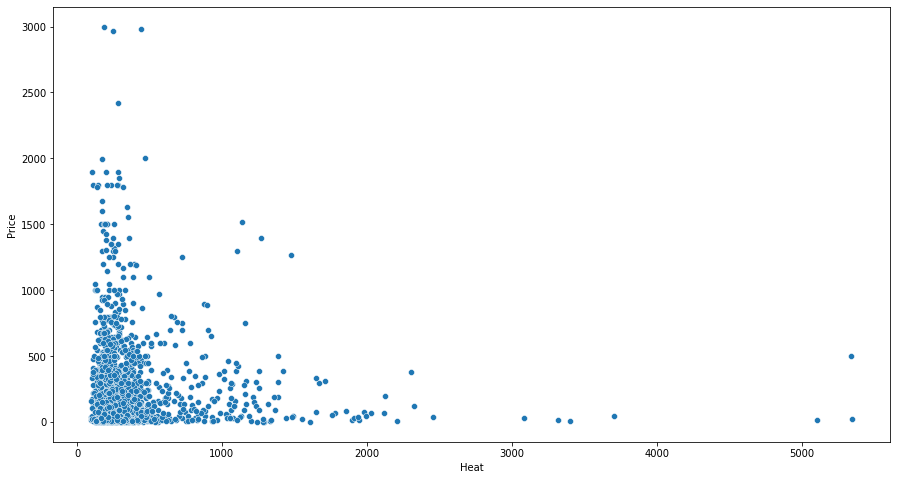

In [18]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.scatterplot(df['Heat'], df['Price'])

(18525.0, 18550.893329848936)

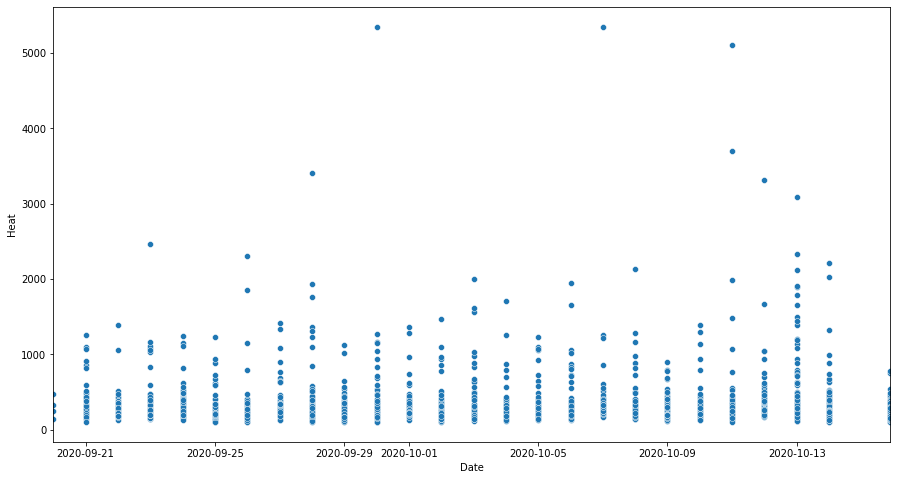

In [19]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.scatterplot(df['Date'], df['Heat'])
ax.set_xlim(df['Date'].min(), df['Date'].max())

In [8]:
df['Item'] = df['Item'].map(lambda x: clean_item(x))

In [20]:
get_top_twenty_words(df['Item'], 40)

black         0.088506
lenovo        0.086239
ebay          0.084475
huawei        0.083897
google        0.083823
dell          0.083548
prime         0.079387
gb            0.077447
apple         0.073549
usb           0.072796
samsung       0.072450
lg            0.070466
64gb          0.070453
drive         0.070244
echo          0.070175
sony          0.066590
wireless      0.066322
128gb         0.065032
delivered     0.065025
currys        0.064903
xiaomi        0.064444
exclusive     0.063148
alexa         0.063116
hd            0.062665
camera        0.062608
pc            0.062152
headphones    0.061909
watch         0.061879
sim           0.061133
free          0.060986
dtype: float64